In [9]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io, measure, feature
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage import io, color
import mahotas as mh
from skimage.util import view_as_windows

In [3]:
# Access the dataset folder
AllDatasetDirPath = r"D:\AI-Practical-Tasks\2023-2024\final\Group D\MangoLeafBD Dataset"
FolderList = my_list = os.listdir(AllDatasetDirPath)
print(FolderList)

['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


In [4]:
def create_dataset(dataset_dir):
    names = [f'haralick_{i+1}' for i in range(13)]
    names.append('classlabel')
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)

            # Convert the image to Grayscale
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
            
            # Texture based features
            textures = mt.features.haralick(gray)
            ht_mean = list(textures.mean(axis=0))
            ht_mean.append(class_label)
            
            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([ht_mean], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [5]:
dataset = create_dataset(AllDatasetDirPath)

C:\Users\sakor\AppData\Local\Temp\ipykernel_18796\2330880463.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(


In [6]:
dataset.shape

(4000, 14)

In [7]:
dataset.head()

,haralick_1,haralick_2,haralick_3,haralick_4,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12,haralick_13,classlabel
0,0.007147,10.731971,0.992615,726.491899,0.667995,325.612999,2895.235624,7.128498,8.494116,0.001702,2.097500,-0.631744,0.999787,0
1,0.006184,11.945924,0.991202,678.819586,0.667219,331.865328,2703.332419,7.211983,8.586526,0.001587,2.090027,-0.632871,0.999808,0
2,0.003973,11.718123,0.993511,902.801434,0.624838,308.885450,3599.487611,7.612117,9.203114,0.001391,2.243520,-0.618325,0.999855,0
3,0.003307,12.300646,0.993161,899.266780,0.623637,304.511709,3584.766473,7.725271,9.321460,0.001393,2.232184,-0.622365,0.999879,0
4,0.004291,21.505493,0.990561,1139.037807,0.579790,330.752689,4534.645735,7.593106,9.424601,0.001187,2.542277,-0.578113,0.999740,0


In [8]:
dataset.to_csv("haralick_features.csv")

In [ ]:
def overlay_features(image_path):
    # Read the image
    main_img = cv2.imread(image_path)
    original_img = main_img.copy()  # Create a copy for visualization

    # Preprocessing
    gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    contours, _ = cv2.findContours(
        thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    leaf_contour = max(contours, key=cv2.contourArea)

    # Extract features
    x, y, w, h = cv2.boundingRect(leaf_contour)
    area = cv2.contourArea(leaf_contour)
    perimeter = cv2.arcLength(leaf_contour, True)
    physiological_length = max(w, h)
    physiological_width = min(w, h)
    aspect_ratio = float(physiological_length) / physiological_width

    # Visualize the image with features overlay
    cv2.rectangle(
        original_img, (x, y), (x + w, y + h), (0, 255, 0), 2
    )  # Draw bounding box

    # Annotate extracted features
    text = (
        f"Area: {area:.2f}, Perimeter: {perimeter:.2f},Aspect Ratio: {aspect_ratio:.2f}"
    )
    cv2.putText(
        original_img,
        text,
        (0, y + 300),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.266,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )

    # Display the image with annotations
    plt.figure(figsize=(10, 18))
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Image with Extracted Features Overlay")
    plt.axis("off")
    plt.show()

In [ ]:
# Example usage
image_path = r"D:\AI-Practical-Tasks\2023-2024\final\Group D\MangoLeafBD Dataset\Anthracnose\20211008_124249 (Custom).jpg"  # Replace this with the path to your image file
overlay_features(image_path)

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
import mahotas as mh
import matplotlib.pyplot as plt

# Read the image
img_path =r"D:\AI-Practical-Tasks\2023-2024\final\Group D\MangoLeafBD Dataset\Anthracnose\20211008_124249 (Custom).jpg" # Replace with the actual path of your image
main_img = cv2.imread(img_path)

# Convert the image to Grayscale
gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)

# Extract SIFT features
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
sift_features = descriptors.flatten() if descriptors is not None else np.zeros(128)  # Assuming 128-dimensional SIFT descriptors

# Compute HOG features
hog = cv2.HOGDescriptor()
hog_features = hog.compute(gray).flatten()

# Extract LBP features
lbp_radius = 3
lbp_points = 8 * lbp_radius
lbp = local_binary_pattern(gray, lbp_points, lbp_radius, method='uniform')
lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
lbp_features = lbp_hist / np.sum(lbp_hist)

# Extract Haralick texture features
textures = mh.features.haralick(gray)
ht_mean = textures.mean(axis=0)
haralick_features = ht_mean[:14]  # Assuming 14 Haralick features

# Compute Canny edges
edges = cv2.Canny(gray, 100, 200)

# Display the extracted features
print("SIFT Features:", sift_features[:2])  # Displaying first 2 SIFT features as an example
print("HOG Features:", hog_features[:2])  # Displaying first 2 HOG features as an example
print("LBP Features:", lbp_features[:2])  # Displaying first 2 LBP features as an example
print("Haralick Features:", haralick_features[:2])  # Displaying first 2 Haralick features as an example

# Visualizing LBP Features
plt.subplot(1, 2, 1)
lbp_img = lbp.astype(np.uint8)  # Convert LBP features to uint8 for visualization
plt.imshow(lbp_img, cmap='gray')
plt.title('Local Binary Patterns (LBP)')
plt.axis('off')

# Visualizing Canny Edges
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# sift
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress tracking

def calculate_features(gray):
    # Extract SIFT features
    gray = cv2.resize(gray, (100,100))
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    sift_features = descriptors.flatten() if descriptors is not None else np.zeros(128)
   
    return sift_features

def create_dataset(dataset_dir):
    names = ["SIFT"]

    all_dataset_results = pd.DataFrame(columns=names)

    categories = next(os.walk(dataset_dir))[1]

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)

            # Convert the image to Grayscale
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)

            # Calculate features
            features = calculate_features(gray)

            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([[features]], columns=names)
            df_temp['classlabel'] = class_label
            all_dataset_results = pd.concat([all_dataset_results, df_temp], ignore_index=True)

    return all_dataset_results



In [ ]:
dataset = create_dataset(AllDatasetDirPath)

In [ ]:
dataset.to_csv("features1.csv")

In [ ]:
dataset.shape

In [ ]:
dataset.head()

86184 (240, 320)
[ 6.32704810e-03  1.35025037e+01  9.90583338e-01  7.16889000e+02
  6.21781544e-01  3.15519587e+02  2.85405349e+03  7.18378508e+00
  8.78861386e+00  1.48934501e-03  2.32219109e+00 -5.94498318e-01
  9.99676772e-01]


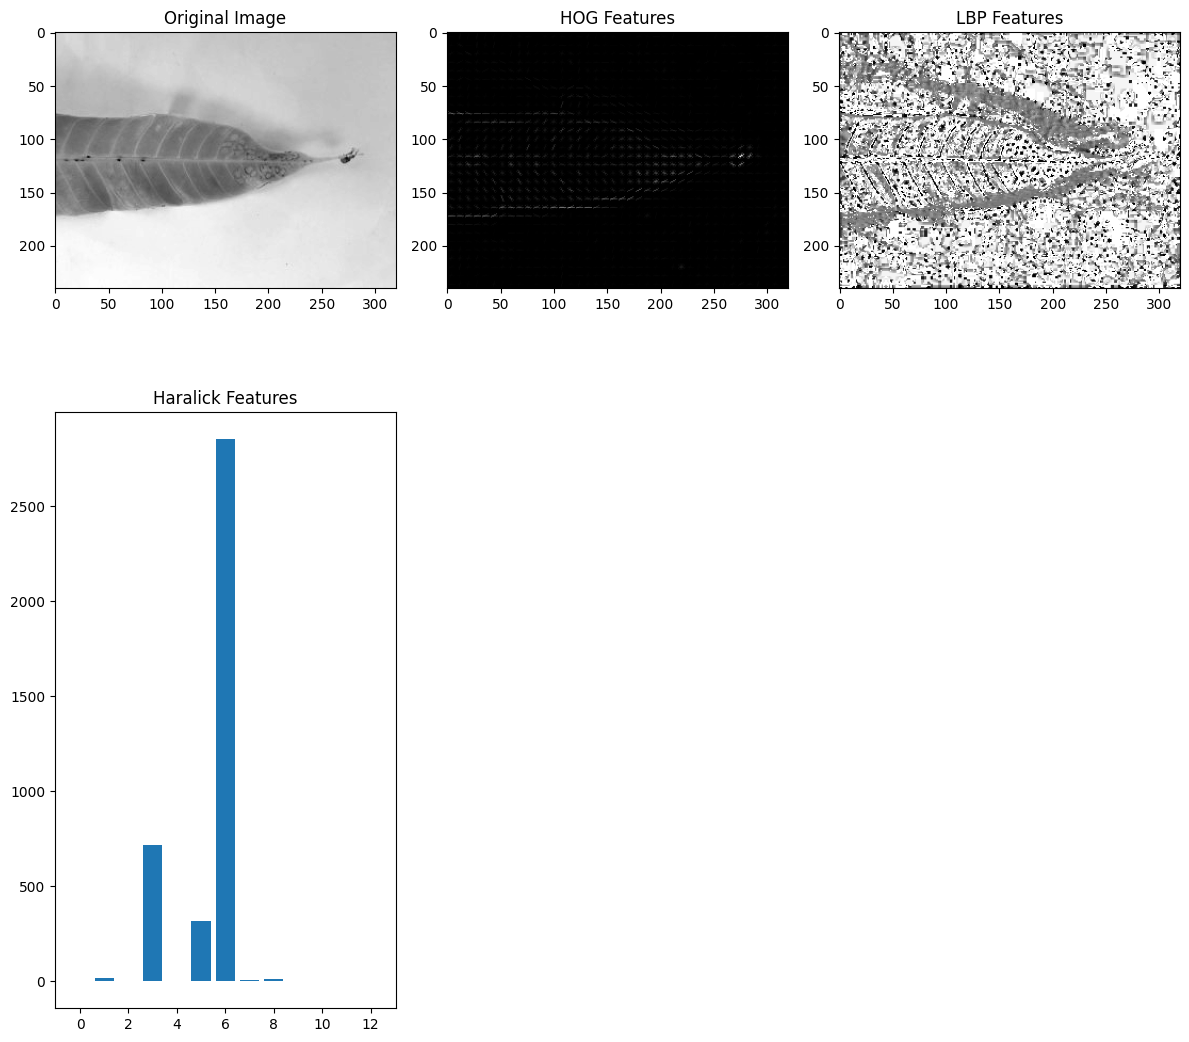

In [29]:
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage import io, color
import mahotas as mh
from skimage.util import view_as_windows

# Load an example image
image = io.imread(r"D:\AI-Practical-Tasks\2023-2024\final\Group D\MangoLeafBD Dataset\Anthracnose\20211008_124249 (Custom).jpg", as_gray=True)

# HOG feature extraction
hog_features, hog_image = hog(image, orientations=9, pixels_per_cell=(8,8),
                              cells_per_block=(3,3), visualize=True, block_norm='L2-Hys')

# LBP feature extraction
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(image, n_points, radius, method='uniform')
print(len(hog_features),lbp.shape)
image_int = (image * 255).astype(int)  # Convert to integer type (0-255 range)

# Haralick feature extraction
textures = view_as_windows(image_int, (32, 32))
haralick_features = mh.features.haralick(textures[:, :, 0, 0]).mean(axis=0)
print(haralick_features)
# Displaying the results or further processing as needed
plt.figure(figsize=(12, 12))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')

plt.subplot(2, 3, 3)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Features')

plt.subplot(2, 3, 4)
plt.bar(range(len(haralick_features)), haralick_features)
plt.title('Haralick Features')

plt.tight_layout()
plt.show()


In [47]:
def create_dataset(dataset_dir):
    names = [f'hog_{i+1}' for i in range(7200)]
    names.append('classlabel')
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img= cv2.resize(main_img,(100,100))
            gray = cv2.cvtColor(main_img,cv2.COLOR_BGR2GRAY)
            hog_features = hog(gray, orientations=8, pixels_per_cell=(8,8),
                              cells_per_block=(3,3), visualize=False, block_norm='L2-Hys')
            hog_features = list(hog_features)
            hog_features.append(class_label)
            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([hog_features], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [48]:
dataset = create_dataset(AllDatasetDirPath)

Processing Anthracnose:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\sakor\AppData\Local\Temp\ipykernel_18796\2341702944.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(
Processing Sooty Mould: 100%|██████████| 500/500 [01:36<00:00,  5.16it/s]


In [49]:
dataset.shape

(4000, 7201)

In [50]:
dataset.head()

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,...,hog_7192,hog_7193,hog_7194,hog_7195,hog_7196,hog_7197,hog_7198,hog_7199,hog_7200,classlabel
0,0.117912,0.018833,0.047644,0.000000,0.218980,0.018833,0.102209,0.0,0.178235,0.086865,...,0.000000,0.142456,0.026545,0.033577,0.000000,0.213684,0.026545,0.093699,0.000000,0
1,0.071457,0.000000,0.260840,0.000000,0.260840,0.260840,0.008421,0.0,0.202461,0.260840,...,0.000000,0.120905,0.045059,0.122271,0.000000,0.171282,0.000000,0.173297,0.000000,0
2,0.106512,0.020414,0.059148,0.000000,0.154318,0.053332,0.041933,0.0,0.069994,0.006805,...,0.000000,0.226115,0.055403,0.071501,0.058763,0.117690,0.041552,0.226115,0.045127,0
3,0.110630,0.023074,0.092535,0.021755,0.177868,0.035477,0.017421,0.0,0.052154,0.000000,...,0.018158,0.223877,0.059222,0.145145,0.000000,0.069836,0.000000,0.180148,0.000000,0
4,0.023160,0.007768,0.018280,0.000000,0.025476,0.000000,0.031797,0.0,0.295848,0.195464,...,0.000000,0.164250,0.016694,0.052792,0.000000,0.143983,0.060307,0.220673,0.023609,0


In [51]:
dataset.to_csv("hog_features.csv")

In [41]:
def create_dataset(dataset_dir):
    names = [f'lbp_{i+1}' for i in range(10000)]
    names.append('classlabel')
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img= cv2.resize(main_img,(100,100))
            gray = cv2.cvtColor(main_img,cv2.COLOR_BGR2GRAY)
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
            # Append the feature vector to the DataFrame
            lbp= list(lbp.flatten())
            lbp.append(class_label)
            df_temp = pd.DataFrame([lbp], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [43]:
dataset = create_dataset(AllDatasetDirPath)

Processing Anthracnose:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\sakor\AppData\Local\Temp\ipykernel_18796\1270704138.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(
Processing Sooty Mould: 100%|██████████| 500/500 [02:12<00:00,  3.77it/s]


In [44]:
dataset.shape

(4000, 10001)

In [45]:
dataset.head()

,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,lbp_10,...,lbp_9992,lbp_9993,lbp_9994,lbp_9995,lbp_9996,lbp_9997,lbp_9998,lbp_9999,lbp_10000,classlabel
0,25.0,8.0,25.0,25.0,13.0,25.0,25.0,25.0,25.0,1.0,...,0.0,8.0,25.0,13.0,13.0,25.0,9.0,8.0,7.0,0
1,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,...,25.0,25.0,25.0,2.0,25.0,0.0,25.0,1.0,7.0,0
2,7.0,8.0,8.0,6.0,7.0,11.0,10.0,13.0,13.0,13.0,...,7.0,7.0,5.0,9.0,10.0,7.0,9.0,8.0,7.0,0
3,6.0,8.0,7.0,7.0,4.0,4.0,9.0,10.0,13.0,13.0,...,7.0,6.0,8.0,7.0,25.0,7.0,5.0,5.0,25.0,0
4,0.0,0.0,1.0,4.0,8.0,13.0,25.0,25.0,3.0,25.0,...,25.0,0.0,0.0,25.0,25.0,5.0,3.0,1.0,25.0,0


In [46]:
dataset.to_csv("lbp_features.csv")

In [55]:
def create_dataset(dataset_dir):
    names = [f'edge_{i+1}' for i in range(10000)]
    names.append('classlabel')
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img= cv2.resize(main_img,(100,100))
            gray = cv2.cvtColor(main_img,cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray,100,200)
            edges= list(edges.flatten())
            edges.append(class_label)
            df_temp = pd.DataFrame([edges], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [56]:
dataset = create_dataset(AllDatasetDirPath)

Processing Sooty Mould: 100%|██████████| 500/500 [03:31<00:00,  2.36it/s]


In [57]:
dataset.shape

(4000, 10001)

In [58]:
dataset.head()

,edge_1,edge_2,edge_3,edge_4,edge_5,edge_6,edge_7,edge_8,edge_9,edge_10,...,edge_9992,edge_9993,edge_9994,edge_9995,edge_9996,edge_9997,edge_9998,edge_9999,edge_10000,classlabel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
dataset.to_csv("features/edges.csv")